Ejemplos aleatorios: [380, 99, 935, 907]


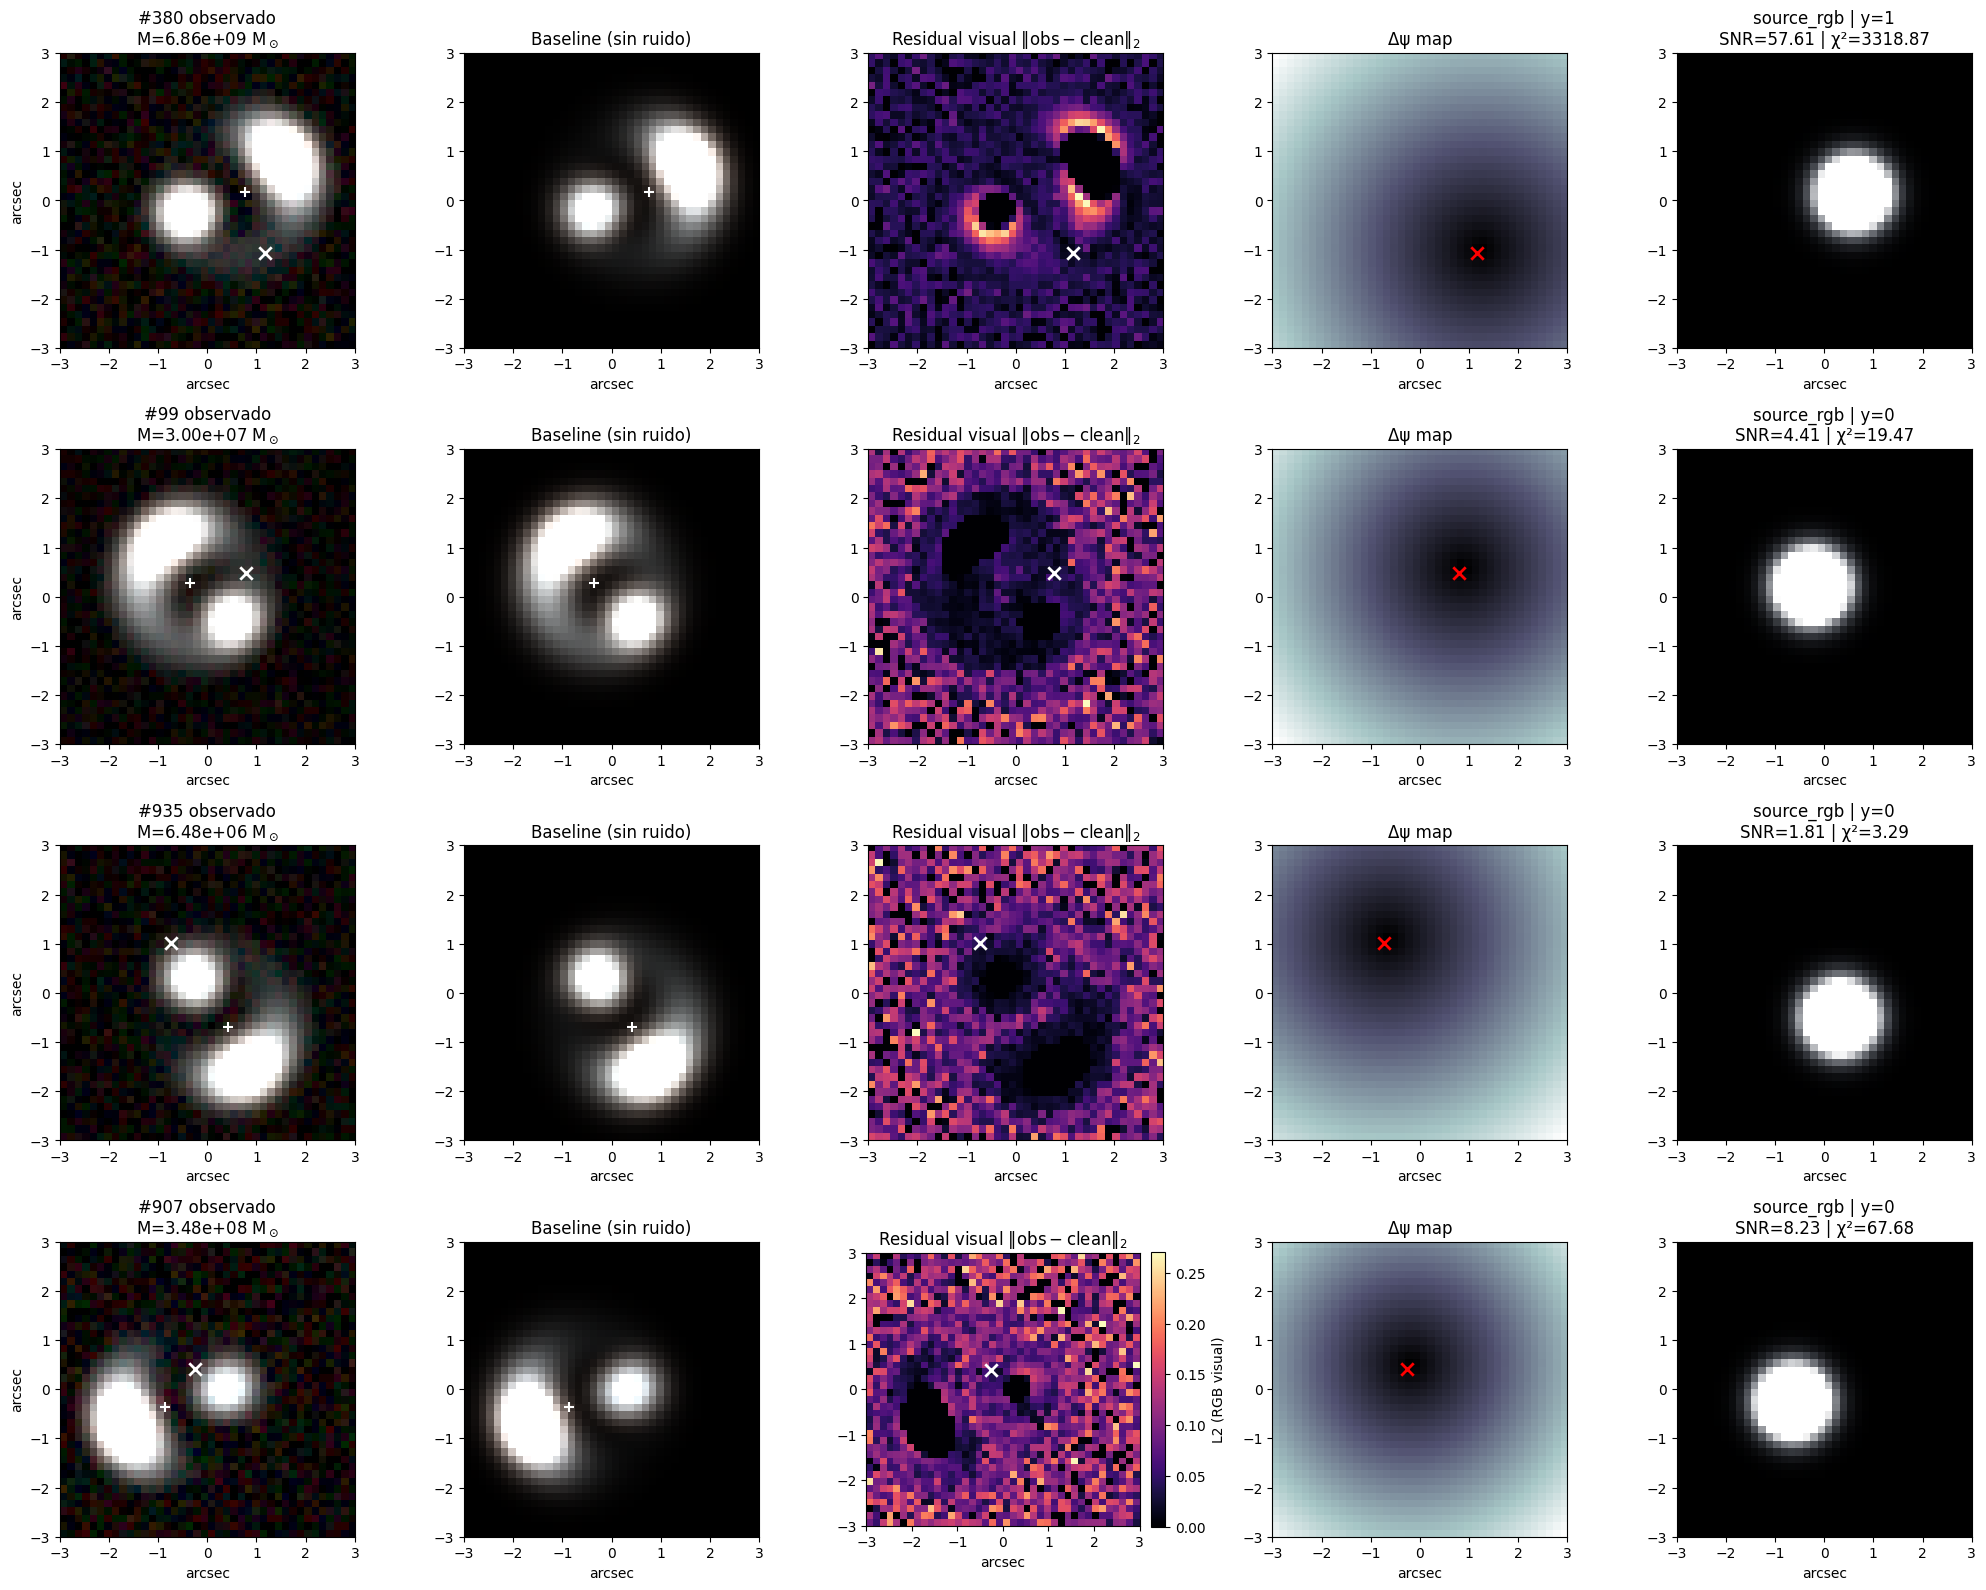

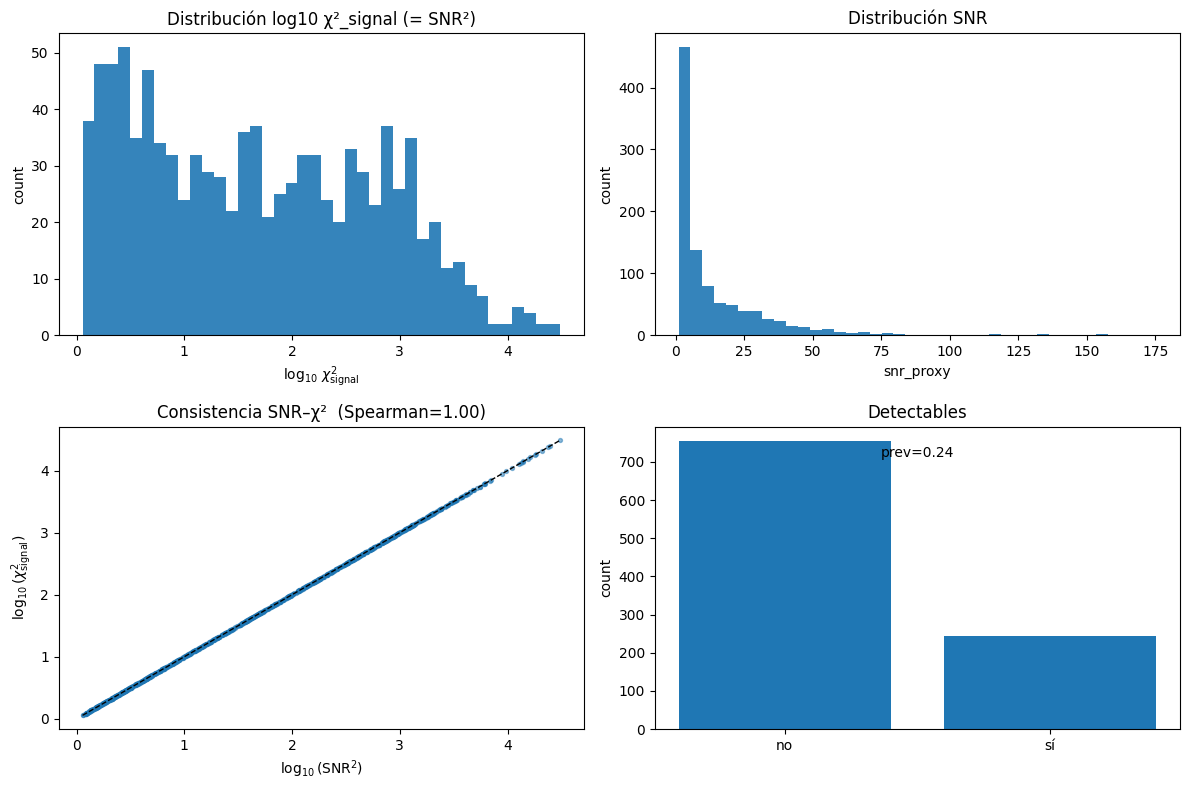

In [1]:
# explore_lsst_lensing_h5 — random sampler + diagnósticos (SIN máscara; residual calculado aquí)
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# ======================
# Parámetros
# ======================
h5_path = 'LSST_chi2_dataset_2.h5'  # ajusta si procede
N_EXAMPLES = 4
RANDOM_SEED = None
P_STRETCH = 95  # solo para visualizar otras cosas si hiciera falta

# -----------------------------
# Helpers
# -----------------------------
def _pick_attr(attrs, name, default=None, cast=float):
    try:
        return cast(attrs[name])
    except Exception:
        return default

def _extent_from_attrs(f, shape_hw=None):
    if 'stamp_size_arcsec' in f.attrs:
        L = float(f.attrs['stamp_size_arcsec'])
        return [-L/2, L/2, -L/2, L/2]
    if shape_hw is None:
        return [-3, 3, -3, 3]
    H, W = shape_hw
    ps = _pick_attr(f.attrs, 'pixel_scale_arcsec', 0.15)
    return [-W*ps/2, W*ps/2, -H*ps/2, H*ps/2]

def _pclip(a, p=95):
    flat = a.reshape(-1)
    if flat.size == 0: return 1.0
    k = int(p/100.0 * (flat.size-1))
    k = max(0, min(k, flat.size-1))
    return float(np.partition(flat, k)[k])

def _safe_log10(x, lo=1e-12, hi=1e20):
    x = np.asarray(x, float)
    return np.log10(np.clip(x, lo, hi))

def _l2_rgb(delta_rgb):
    return np.sqrt(np.sum(delta_rgb**2, axis=-1))

# -----------------------------
# Visualización
# -----------------------------
with h5py.File(h5_path, 'r') as f:
    # Claves esperadas del dataset actual
    k_obs   = 'images_rgb'          # (N,H,W,3) con subhalo + ruido (visual/sqrt-stretch si así se guardó)
    k_clean = 'images_clean'        # (N,H,W,3) baseline SIN ruido (visual/sqrt-stretch)
    k_dpsi  = 'delta_psi_maps'      # (N,H,W)
    k_src   = 'source_rgb'          # (N,H,W,3) si existe (opcional, LSST-like compuesto)

    X = f[k_obs]
    N, H, W, C = X.shape
    extent = _extent_from_attrs(f, (H, W))

    # ejemplos aleatorios
    rng = np.random.default_rng(RANDOM_SEED) if RANDOM_SEED is not None else np.random.default_rng()
    n_examples = min(N_EXAMPLES, N)
    idxs = rng.choice(np.arange(N), size=n_examples, replace=False)
    print("Ejemplos aleatorios:", idxs.tolist())

    # Figura: obs | clean | residual (|obs-clean|_L2) | Δψ | source_rgb
    ncols = 5
    fig, axes = plt.subplots(len(idxs), ncols, figsize=(4*ncols, 4*len(idxs)))
    if len(idxs) == 1:
        axes = np.expand_dims(axes, 0)

    for row, idx in enumerate(idxs):
        mass  = f['subhalo_mass'][idx] if 'subhalo_mass' in f else np.nan
        x_sub = f['subhalo_x'][idx] if 'subhalo_x' in f else np.nan
        y_sub = f['subhalo_y'][idx] if 'subhalo_y' in f else np.nan
        x_src = f['source_x'][idx]   if 'source_x'   in f else np.nan
        y_src = f['source_y'][idx]   if 'source_y'   in f else np.nan

        snr_val = f['snr_proxy'][idx]       if 'snr_proxy'    in f else np.nan
        chi2sig = f['chi2_signal'][idx]     if 'chi2_signal'  in f else np.nan
        ybin    = f['is_detectable'][idx]   if 'is_detectable' in f else -1

        # (1) observado
        ax = axes[row, 0]
        obs = f[k_obs][idx]
        ax.imshow(obs, origin='lower', extent=extent, interpolation='nearest')
        if np.isfinite(x_sub) and np.isfinite(y_sub): ax.scatter([x_sub],[y_sub], s=80, marker='x', lw=2, c='w')
        if np.isfinite(x_src) and np.isfinite(y_src): ax.scatter([x_src],[y_src], s=60, marker='+', lw=1.5, c='w')
        ax.set_title(f"#{idx} observado\nM={mass:.2e} M$_\\odot$")
        ax.set_xlabel("arcsec"); ax.set_ylabel("arcsec")

        # (2) baseline clean
        ax = axes[row, 1]
        clean = f[k_clean][idx]
        ax.imshow(clean, origin='lower', extent=extent, interpolation='nearest')
        if np.isfinite(x_src) and np.isfinite(y_src): ax.scatter([x_src],[y_src], s=60, marker='+', lw=1.5, c='w')
        ax.set_title("Baseline (sin ruido)"); ax.set_xlabel("arcsec")

        # (3) residual visual: |obs - clean|_L2 por píxel
        ax = axes[row, 2]
        resid_rgb = obs - clean                      # en espacio visual (sqrt-stretch)
        resid_l2  = _l2_rgb(resid_rgb)
        im = ax.imshow(resid_l2, origin='lower', extent=extent, cmap='magma', interpolation='nearest')
        if np.isfinite(x_sub) and np.isfinite(y_sub): ax.scatter([x_sub],[y_sub], s=80, marker='x', lw=2, c='w')
        ax.set_title(r"Residual visual $\|\mathrm{obs-clean}\|_2$")
        ax.set_xlabel("arcsec")
        if row == len(idxs)-1:
            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.ax.set_ylabel("L2 (RGB visual)")

        # (4) Δψ
        ax = axes[row, 3]
        ax.imshow(f[k_dpsi][idx], origin='lower', extent=extent, cmap='bone', interpolation='nearest')
        if np.isfinite(x_sub) and np.isfinite(y_sub): ax.scatter([x_sub],[y_sub], s=80, marker='x', lw=2, c='r')
        ax.set_title("Δψ map"); ax.set_xlabel("arcsec")

        # (5) source_rgb (si existe) + métricas
        ax = axes[row, 4]
        if k_src in f:
            ax.imshow(f[k_src][idx], origin='lower', extent=extent, interpolation='nearest')
        else:
            ax.text(0.5, 0.5, 'source_rgb no disponible', transform=ax.transAxes,
                    ha='center', va='center')
        ax.set_title(
            f"source_rgb | y={int(ybin)}\n"
            f"SNR={snr_val:.2f} | χ²={chi2sig:.2f}"
        )
        ax.set_xlabel("arcsec")

    plt.tight_layout(); plt.show()

    # ===========================================
    # 2) DIAGNÓSTICOS EN UNA SOLA FIGURA (subplots)
    # ===========================================
    snr   = f['snr_proxy'][:]    if 'snr_proxy'    in f else None
    chi2s = f['chi2_signal'][:]  if 'chi2_signal'  in f else None
    ybin  = f['is_detectable'][:] if 'is_detectable' in f else None

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    ax11, ax12 = axs[0]
    ax21, ax22 = axs[1]

    # (1,1) Distribución log10(χ²_signal)
    if chi2s is not None:
        chi2_log = _safe_log10(chi2s)
        ax11.hist(chi2_log[np.isfinite(chi2_log)], bins=40, alpha=.9)
        ax11.set_xlabel(r'$\log_{10}\,\chi^2_{\rm signal}$'); ax11.set_ylabel("count")
        ax11.set_title("Distribución log10 χ²_signal (= SNR²)")
    else:
        chi2_log = None
        ax11.axis('off'); ax11.set_title("χ²_signal no disponible")

    # (1,2) Distribución SNR
    if snr is not None:
        ax12.hist(snr[np.isfinite(snr)], bins=40, alpha=.9)
        ax12.set_xlabel("snr_proxy"); ax12.set_ylabel("count")
        ax12.set_title("Distribución SNR")
    else:
        ax12.axis('off'); ax12.set_title("snr_proxy no disponible")

    # (2,1) Consistencia: log10 χ²_signal vs log10 SNR²  (deberían alinearse ~ y=x)
    if (snr is not None) and (chi2s is not None):
        m = np.isfinite(snr) & np.isfinite(chi2s) & (snr > 0) & (chi2s > 0)
        x = 2.0 * np.log10(snr[m])    # log10(SNR^2)
        y = np.log10(chi2s[m])        # log10(χ²_signal)
        ax21.scatter(x, y, s=8, alpha=.5)
        lims = [min(x.min(), y.min()), max(x.max(), y.max())]
        ax21.plot(lims, lims, 'k--', lw=1)  # y = x
        rho, _ = spearmanr(x, y) if m.any() else (np.nan, np.nan)
        ax21.set_xlabel(r'$\log_{10}(\mathrm{SNR}^2)$'); ax21.set_ylabel(r'$\log_{10}(\chi^2_{\rm signal})$')
        ax21.set_title(f'Consistencia SNR–χ²  (Spearman={rho:.2f})')
    else:
        ax21.axis('off'); ax21.set_title("Consistencia no disponible")

    # (2,2) Prevalencia (si hay etiquetas)
    if ybin is not None:
        ybin = ybin.astype(int)
        n_pos = int((ybin == 1).sum()); n_neg = int((ybin == 0).sum())
        ax22.bar(['no', 'sí'], [n_neg, n_pos])
        ax22.set_title('Detectables'); ax22.set_ylabel('count')
        ax22.text(0.5, 0.9, f'prev={n_pos/max(len(ybin),1):.2f}', transform=ax22.transAxes, ha='center')
    else:
        ax22.axis('off'); ax22.set_title("Etiquetas no disponibles")

    plt.tight_layout(); plt.show()


=== Summary of metrics ===
            SNR: N=1000 | mean=14.8 | std=21 | p5=1.25 | median=6.29 | p95=52.7
      χ² (xi^2): N=1000 | mean=661 | std=2.31e+03 | p5=1.56 | median=39.6 | p95=2.78e+03
         χ²_red: N=1000 | mean=0.734 | std=2.56 | p5=0.00173 | median=0.044 | p95=3.09
Labels: positives=245, negatives=755, prevalence=0.245


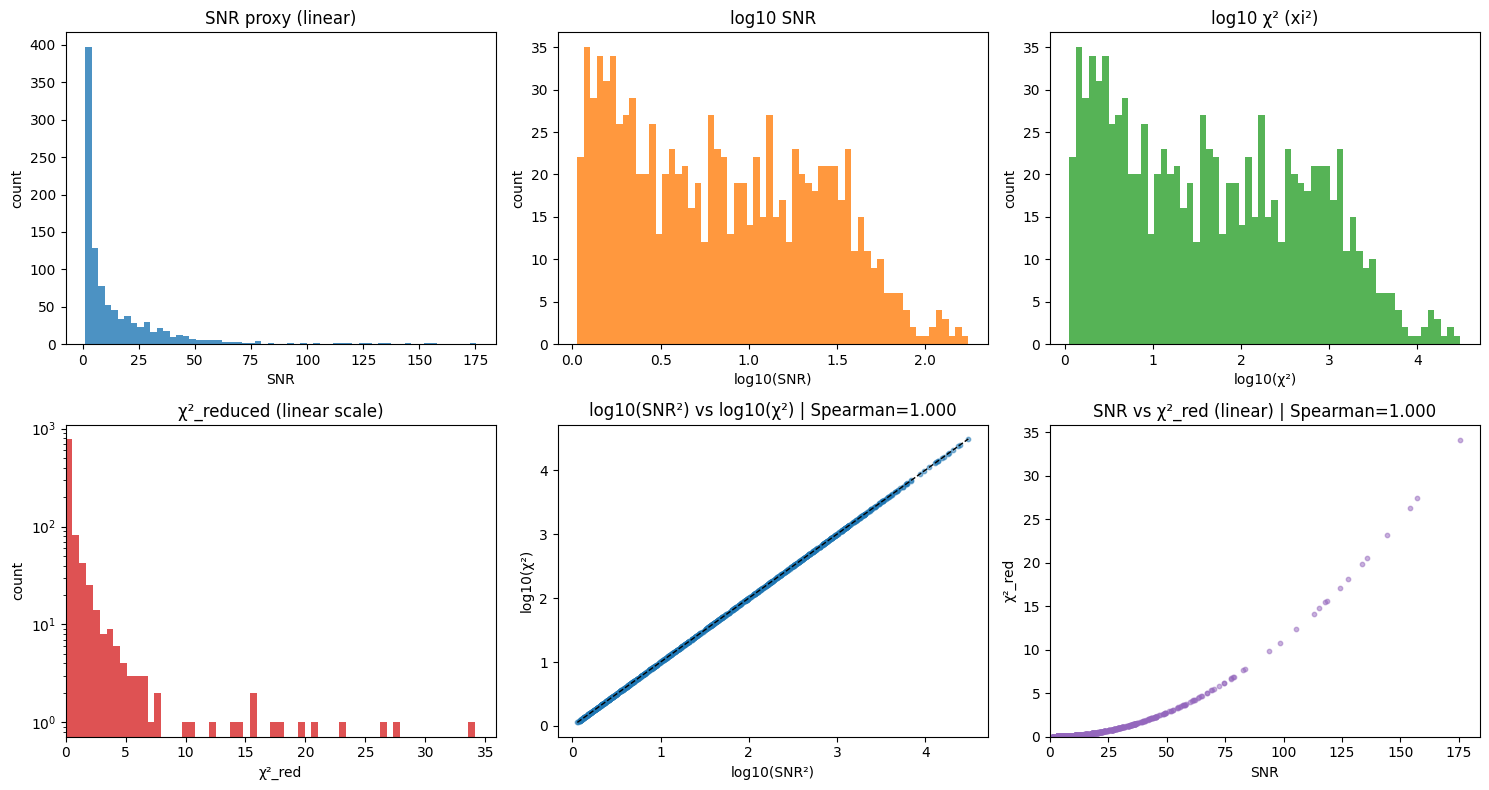

      χ² / SNR²: N=1000 | mean=1 | std=0 | p5=1 | median=1 | p95=1


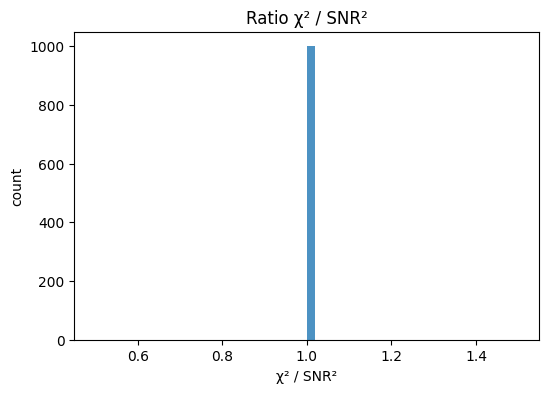

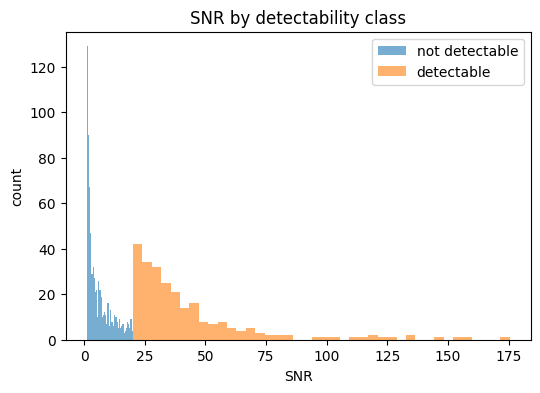

In [6]:
# === Exploración visual y analítica de SNR, χ² y χ²_reducida (versión lineal en χ²_red) ===
import h5py, numpy as np, matplotlib.pyplot as plt
from scipy.stats import spearmanr

# ---- Config ----
h5_path = 'LSST_chi2_dataset_2.h5'
DOF = 900  # número de píxeles (por ejemplo 30x30)

# ---- Funciones auxiliares ----
def _safe(x):
    return np.asarray(x)[np.isfinite(x)]

def _log10_clip(x, lo=1e-20, hi=1e20):
    x = np.clip(np.asarray(x, float), lo, hi)
    return np.log10(x)

def describe(name, arr):
    a = _safe(arr)
    q = np.percentile(a, [0,5,50,95,100])
    print(f"{name:>15s}: N={len(a)} | mean={a.mean():.3g} | std={a.std():.3g} | "
          f"p5={q[1]:.3g} | median={q[2]:.3g} | p95={q[3]:.3g}")

# ---- Carga de datos ----
with h5py.File(h5_path, "r") as f:
    snr = f["snr_proxy"][:] if "snr_proxy" in f else None
    chi2 = f["chi2_stat"][:] if "chi2_stat" in f else snr**2
    chi2_red = f["chi2_reduced"][:] if "chi2_reduced" in f else chi2 / DOF
    ybin = f["is_detectable"][:] if "is_detectable" in f else None

# ---- Cálculos adicionales ----
xi = chi2
xi_red = chi2_red

# ---- Resumen estadístico ----
print("=== Summary of metrics ===")
describe("SNR", snr)
describe("χ² (xi^2)", xi)
describe("χ²_red", xi_red)
if ybin is not None:
    y = np.asarray(ybin).astype(int)
    print(f"Labels: positives={np.sum(y==1)}, negatives={np.sum(y==0)}, prevalence={np.mean(y):.3f}")

# ---- Gráficos ----
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.ravel()

# 1. Histograma SNR (lineal)
axs[0].hist(_safe(snr), bins=60, alpha=.8)
axs[0].set_title("SNR proxy (linear)")
axs[0].set_xlabel("SNR"); axs[0].set_ylabel("count")

# 2. Histograma log10 SNR
axs[1].hist(_log10_clip(_safe(snr)), bins=60, alpha=.8, color='tab:orange')
axs[1].set_title("log10 SNR")
axs[1].set_xlabel("log10(SNR)"); axs[1].set_ylabel("count")

# 3. χ² (log10)
axs[2].hist(_log10_clip(_safe(xi)), bins=60, alpha=.8, color='tab:green')
axs[2].set_title("log10 χ² (xi²)")
axs[2].set_xlabel("log10(χ²)"); axs[2].set_ylabel("count")

# 4. χ² reducida (sin log)
axs[3].hist(_safe(xi_red), bins=60, alpha=.8, color='tab:red')
axs[3].set_title("χ²_reduced (linear scale)")
axs[3].set_xlabel("χ²_red"); axs[3].set_ylabel("count")
axs[3].set_xlim(left=0)  # no negativos
axs[3].set_yscale('log')  # útil si hay cola larga

# 5. Scatter χ² vs SNR² (log-log)
m = np.isfinite(snr) & np.isfinite(xi) & (snr>0)
x, y = np.log10(snr[m]**2), np.log10(xi[m])
rho, _ = spearmanr(x, y)
axs[4].scatter(x, y, s=10, alpha=.5)
lims = [min(x.min(), y.min()), max(x.max(), y.max())]
axs[4].plot(lims, lims, 'k--', lw=1)
axs[4].set_title(f"log10(SNR²) vs log10(χ²) | Spearman={rho:.3f}")
axs[4].set_xlabel("log10(SNR²)")
axs[4].set_ylabel("log10(χ²)")

# 6. χ²_reducida vs SNR (lineales)
m = np.isfinite(snr) & np.isfinite(xi_red) & (snr>0)
x, y = snr[m], xi_red[m]
rho2, _ = spearmanr(x, y)
axs[5].scatter(x, y, s=10, alpha=.5, color='tab:purple')
axs[5].set_title(f"SNR vs χ²_red (linear) | Spearman={rho2:.3f}")
axs[5].set_xlabel("SNR")
axs[5].set_ylabel("χ²_red")
axs[5].set_xlim(left=0)
axs[5].set_ylim(bottom=0)

plt.tight_layout()
plt.show()

# ---- Relaciones cuantitativas ----
if snr is not None and xi is not None:
    ratio = xi / (snr**2 + 1e-12)
    describe("χ² / SNR²", ratio)
    plt.figure(figsize=(6,4))
    plt.hist(_safe(ratio), bins=50, alpha=.8)
    plt.title("Ratio χ² / SNR²")
    plt.xlabel("χ² / SNR²"); plt.ylabel("count")
    plt.show()

# ---- Si hay etiquetas, relación con SNR ----
if ybin is not None:
    plt.figure(figsize=(6,4))
    plt.hist(_safe(snr[ybin==0]), bins=40, alpha=.6, label='not detectable')
    plt.hist(_safe(snr[ybin==1]), bins=40, alpha=.6, label='detectable')
    plt.title("SNR by detectability class")
    plt.xlabel("SNR"); plt.ylabel("count"); plt.legend()
    plt.show()
